In [9]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import matplotlib
import xgboost
#import graphviz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss
from pandas.api.types import CategoricalDtype

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

%matplotlib inline

In [10]:
print('* Pandas', pd.__version__)
print('* sklearn', sklearn.__version__)
print('* seaborn', sns.__version__)
print('* matplotlib', matplotlib.__version__)
print('* numpy', np.__version__)
print('* xgboost', np.__version__)




* Pandas 0.25.3
* sklearn 0.23.2
* seaborn 0.10.0
* matplotlib 3.3.2
* numpy 1.19.2
* xgboost 1.19.2


In [4]:
# Load the dataset
data_path = os.path.join(os.getcwd(),  'recipes.csv')
data = pd.read_csv(data_path)
data

,'acorn squash',adobo,'african birdseye chile pepper',ale,'aleppo pepper','alfalfa sprouts','alfredo sauce',allspice,almond,'almond butter',...,yeast,'yellow curry paste','yellow food coloring','yellow split pea','yellow squash',yogurt,zaatar,zest,zucchini,cuisine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
4232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
4233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
4234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11


In [34]:
data['cuisine'].value_counts()

11    353
7     353
3     353
10    353
6     353
2     353
9     353
5     353
1     353
8     353
4     353
0     353
Name: cuisine, dtype: int64

In [3]:
data_clean = data.copy(deep=True) # Make a copy of the DataFrame

# Extract (and print the shape of) X
X = data_clean.drop('cuisine', axis=1)
column_names = X.columns
# Convert to Numpy Array
X = X.values
print('X shape: {}'.format(X.shape))

# Extract the Target y (and print its shape)
data_clean['cuisine'] = data_clean['cuisine'].astype('category') # Convert using astype(...) method
#convert the categorical values into a one-hot-encoding
#y = pd.get_dummies(data_clean['cuisine']) # Target vector
# Convert to Numpy Array
y = data_clean['cuisine']
#y = y.values
print('y shape: {}'.format(np.shape(y)))


X shape: (4236, 709)
y shape: (4236,)


### ========== simple PCA ==========

In [80]:
pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(X)

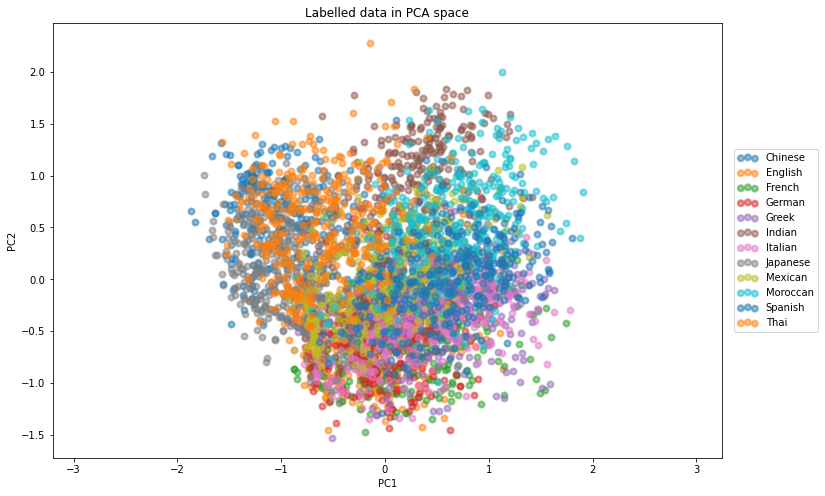

In [23]:
class_categories = ['Chinese', 'English', 'French', 'German', 'Greek', 'Indian', 'Italian', 'Japanese', 'Mexican', 'Moroccan', 'Spanish', 'Thai']
class_labels = []
for i in range(0,12):
    class_labels.append(i)

# PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

y_ = data['cuisine'].values

#X_2d_plot = np.concatenate((X_2d,y_),axis=1)

plt.figure(figsize=(12,8))
for label, cat in zip(class_labels, class_categories):
    plt.scatter(X_2d[y_ == label, 0], X_2d[y_ == label, 1], alpha=.5, lw=2, label=cat)
plt.axis('equal')
plt.legend(loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5])
plt.title('Labelled data in PCA space')
plt.xlabel('PC1')
plt.ylabel('PC2')
top_plot = plt.gca()

plt.savefig('pca_no_kernel.pdf', bbox_inches = 'tight')
plt.show()



## ========== 5-fold Cross Validation ==========
See above, the train acc is much higher than test acc.

In [4]:
#  split off stratified test data (20%) by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
print(skf, skf.get_n_splits(X, y))
for train_index, test_index in skf.split(X, y):
    X_fold, X_cvtest = X[train_index], X[test_index]
    y_fold, y_cvtest = y[train_index], y[test_index]
    
# 20% for test (X_cvtest, y_cvtest) , 80% for train and validate (X_fold, y_fold)

StratifiedKFold(n_splits=5, random_state=0, shuffle=True) 5


In [5]:
#print("TRAIN:", train_index, "TEST:", test_index)

In [6]:
X_fold.shape

(3389, 709)

In [7]:
X_cvtest.shape

(847, 709)

## ========== Baseline ==========

In [55]:
dclf = DummyClassifier(strategy='most_frequent')
#pipe = Pipeline([('scaler', StandardScaler()), ('dclf', dclf)])

score_dclf = cross_val_score(dclf, X_fold, y_fold, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=0))



print("Classification accuracy on the validation set:")
print("'Most-frequent' dummy classifier: {0:.4f}".format(score_dclf.mean()))
      

score_dclf

Classification accuracy on the validation set:
'Most-frequent' dummy classifier: 0.0826


array([0.08259587, 0.08259587, 0.08259587, 0.08259587, 0.08271787])

In [54]:
dclf = DummyClassifier(strategy='uniform')
#pipe = Pipeline([('scaler', StandardScaler()), ('dclf', dclf)])

score_dclf = cross_val_score(dclf, X_fold, y_fold, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=0))



print("Classification accuracy on the validation set:")
print("'uniform' dummy classifier: {0:.4f}".format(score_dclf.mean()))
score_dclf

Classification accuracy on the validation set:
'uniform' dummy classifier: 0.0841


array([0.06342183, 0.06932153, 0.08259587, 0.10324484, 0.10192024])

### ========== 1. Linear SVM (5-fold CV) ==========

In [73]:
# classification accuracy with different C (Penalty parameter C of the error term)
C1 = [0.01, 0.02, 0.05, 0.08, 0.1, 0.5, 1.0, 1.5]
scores_svc_linear = []
for c in C1:
    cv_svc_linear = LinearSVC(C=c, random_state = 0)
    # Returns the mean accuracy on the given test data and labels.
    score_svc_linear = cross_val_score(cv_svc_linear, X_fold, y_fold, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=0))
    scores_svc_linear.append(score_svc_linear)
    print('C = {}, Linear SVC classification accuracy on validation set: {:.3f}'.format(c, score_svc_linear.mean()))
    
scores_svc_linear = np.array(scores_svc_linear)
mean_acc_lsvc = scores_svc_linear.mean(axis = 1)

C = 0.01, Linear SVC classification accuracy on validation set: 0.753
C = 0.02, Linear SVC classification accuracy on validation set: 0.764
C = 0.05, Linear SVC classification accuracy on validation set: 0.770
C = 0.08, Linear SVC classification accuracy on validation set: 0.771
C = 0.1, Linear SVC classification accuracy on validation set: 0.770
C = 0.5, Linear SVC classification accuracy on validation set: 0.750
C = 1.0, Linear SVC classification accuracy on validation set: 0.739
C = 1.5, Linear SVC classification accuracy on validation set: 0.731


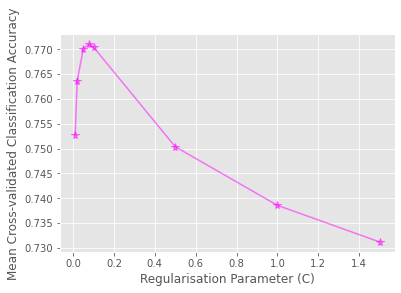

In [74]:
fig, ax = plt.subplots()
#plt.xscale('Penalty parameter C of the error term')
plt.plot(C1, mean_acc_lsvc, marker='*', color = 'magenta',alpha=.5, ms=8)
plt.xlabel("Regularisation Parameter (C)")
plt.ylabel("Mean Cross-validated Classification Accuracy")
plt.style.use('ggplot')
#plt.savefig('2.5.pdf')

In [75]:
# final model using proper parameters:
# c = 0.08
cv_svc_linear = LinearSVC(C=0.08, random_state = 0)
cv_svc_linear.fit(X_fold, y_fold)
print('Final Linear SVC classification accuracy on training set: {:.3f}'.format(cv_svc_linear.score(X_fold, y_fold)))
print('Final Linear SVC classification accuracy on test set: {:.3f}'.format(cv_svc_linear.score(X_cvtest, y_cvtest)))

Final Linear SVC classification accuracy on training set: 0.883
Final Linear SVC classification accuracy on test set: 0.796


### ==========2. Kernel SVM (5-fold CV) ==========

In [76]:
# classification accuracy with different C (Penalty parameter C of the error term)
C2 = [0.5, 1.0, 1.5, 2.0, 3.0, 3.5, 4.0, 4.5, 5.0]
scores = []
for c in C2:
    classifier = SVC(C=c, kernel='rbf', random_state = 0)
    # Returns the mean accuracy on the given test data and labels.
    score = cross_val_score(classifier, X_fold, y_fold, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=0))
    scores.append(score)
    print('C = {}, rbf SVC classification accuracy on validation set: {:.3f}'.format(c, score.mean()))
    
scores = np.array(scores)
mean_acc = scores.mean(axis = 1)

C = 0.5, rbf SVC classification accuracy on validation set: 0.738
C = 1.0, rbf SVC classification accuracy on validation set: 0.752
C = 1.5, rbf SVC classification accuracy on validation set: 0.758
C = 2.0, rbf SVC classification accuracy on validation set: 0.764
C = 3.0, rbf SVC classification accuracy on validation set: 0.760
C = 3.5, rbf SVC classification accuracy on validation set: 0.758
C = 4.0, rbf SVC classification accuracy on validation set: 0.757
C = 4.5, rbf SVC classification accuracy on validation set: 0.759
C = 5.0, rbf SVC classification accuracy on validation set: 0.758


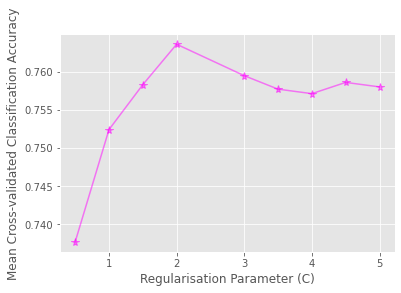

In [77]:
fig, ax = plt.subplots()
#plt.xscale('log')
plt.plot(C2, mean_acc, marker='*', color = 'magenta',alpha=.5, ms=8)
plt.xlabel("Regularisation Parameter (C)")
plt.ylabel("Mean Cross-validated Classification Accuracy")
plt.style.use('ggplot')

In [78]:
# final model using proper parameters:
# c = 2.0
cv_svc_rbf =SVC(C=2.0, kernel='rbf', random_state = 0)
cv_svc_rbf.fit(X_fold, y_fold)
print('Final rbf SVC classification accuracy on training set: {:.3f}'.format(cv_svc_rbf.score(X_fold, y_fold)))
print('Final rbf SVC classification accuracy on test set: {:.3f}'.format(cv_svc_rbf.score(X_cvtest, y_cvtest)))

Final rbf SVC classification accuracy on training set: 0.976
Final rbf SVC classification accuracy on test set: 0.787


### ==========3. Logistic Regression  (5-fold CV)  ==========

In [57]:
# classification accuracy with different C (Penalty parameter C of the error term)
C1 = [0.01, 0.02, 0.05, 0.08, 0.1, 0.5, 1.0, 1.5]
scores = []
for c in C1:
    classifier =  LogisticRegression(C=c, solver='sag', random_state = 0) 
    # Returns the mean accuracy on the given test data and labels.
    score = cross_val_score(classifier, X_fold, y_fold, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=0))
    scores.append(score)
    print('C = {}, rbf SVC classification accuracy on validation set: {:.3f}'.format(c, score.mean()))
    
scores = np.array(scores)
mean_acc = scores.mean(axis = 1)

C = 0.01, rbf SVC classification accuracy on validation set: 0.708
C = 0.02, rbf SVC classification accuracy on validation set: 0.718
C = 0.05, rbf SVC classification accuracy on validation set: 0.734
C = 0.08, rbf SVC classification accuracy on validation set: 0.742
C = 0.1, rbf SVC classification accuracy on validation set: 0.742
C = 0.5, rbf SVC classification accuracy on validation set: 0.763
C = 1.0, rbf SVC classification accuracy on validation set: 0.760
C = 1.5, rbf SVC classification accuracy on validation set: 0.761


In [58]:
# final model using proper parameters:
# c = 0.5
cv_lr =LogisticRegression(C=0.5, solver='sag', random_state = 0) 
cv_lr.fit(X_fold, y_fold)
print('Final lr classification accuracy on training set: {:.3f}'.format(cv_lr.score(X_fold, y_fold)))
print('Final lr classification accuracy on test set: {:.3f}'.format(cv_lr.score(X_cvtest, y_cvtest)))

Final lr classification accuracy on training set: 0.884
Final lr classification accuracy on test set: 0.800


In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = cv_lr.predict(X_cvtest)
cm_test = confusion_matrix(y_cvtest, y_pred)
np.set_printoptions(precision=2)  # only print two significant digits
print('\n Confusion matrix \n{}'.format(cm_test))


 Confusion matrix 
[[51  0  0  0  0  0  0 13  1  0  0  5]
 [ 0 49  7  4  2  2  2  1  1  0  3  0]
 [ 0  3 51  9  0  1  3  0  0  0  3  0]
 [ 0  5  4 58  1  0  1  0  0  1  1  0]
 [ 0  4  3  1 53  1  3  0  0  3  3  0]
 [ 1  2  0  0  0 63  0  1  0  1  0  2]
 [ 0  1  4  1  5  0 55  0  0  0  5  0]
 [13  0  0  1  0  1  0 52  1  0  0  2]
 [ 0  1  0  2  2  1  0  0 65  0  0  0]
 [ 0  0  1  0  0  4  0  0  1 62  3  0]
 [ 0  4  5  0  1  0  1  0  0  1 58  0]
 [ 2  0  0  0  0  4  0  3  1  0  0 61]]


In [150]:
def plot_confusion_matrix(cm, class_labels=None):
    """Plots a confusion matrix using seaborn's heatmap function
    
    Columns and rows are labelled with the strings provided in class_labels.
    
    Parameters
    ----------
    cm: array-like
        contains the confusion matrix
        
    class_labels: array-like, optional
        contains the string labels
            
    """
    
    # check whether we have count data or not
    if issubclass(cm.dtype.type, np.integer):
        fmt = 'd'
    else:
        fmt = '.2f'
    
    # Your code goes here
    
    if class_labels is not None:
        ax=sns.heatmap(cm, cmap='viridis',xticklabels=class_labels, yticklabels=class_labels,\
                    annot=True, annot_kws={"fontsize":9},  fmt=fmt)  # controls the display of the numbers
    else:
        sns.heatmap(cm, annot=True, annot_kws={"fontsize":9},  fmt=fmt)
    
    #plt.rcParams['figure.figsize']=9,9
    ax.figure.set_size_inches(10,6)
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    
    # you can change the appearance of the figure with lower-level matplotlib commands
    # here we rotate the labels on the x-axis
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

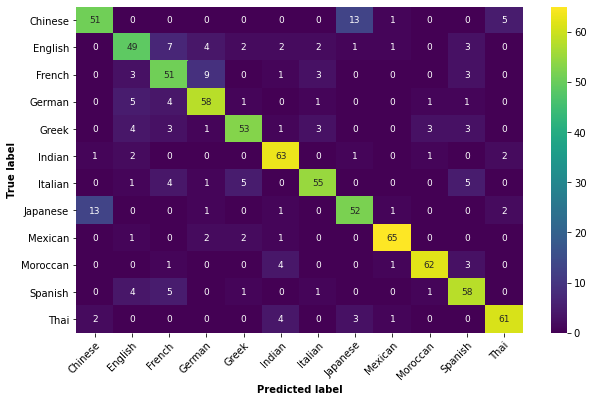

In [152]:
class_categories = ['Chinese', 'English', 'French', 'German', 'Greek', 'Indian', 'Italian', 'Japanese', 'Mexican', 'Moroccan', 'Spanish', 'Thai']
plot_confusion_matrix(cm_test, class_labels=class_categories)
plt.savefig('confu_ma.pdf', bbox_inches = 'tight')

### ==========4. Decision Tree  (5-fold CV)  ==========

In [96]:
# try different max depth
C3 = [10, 15, 20, 25, 30, 40, 45, 50, 55, 60]
scores = []
for c in C3:
    classifier =  DecisionTreeClassifier(max_depth = c, random_state = 0) 
    # Returns the mean accuracy on the given test data and labels.
    score = cross_val_score(classifier, X_fold, y_fold, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=0))
    scores.append(score)
    print('C = {}, decision tree classification accuracy on validation set: {:.3f}'.format(c, score.mean()))
    
scores = np.array(scores)
mean_acc = scores.mean(axis = 1)

C = 10, decision tree classification accuracy on validation set: 0.511
C = 15, decision tree classification accuracy on validation set: 0.560
C = 20, decision tree classification accuracy on validation set: 0.570
C = 25, decision tree classification accuracy on validation set: 0.580
C = 30, decision tree classification accuracy on validation set: 0.591
C = 40, decision tree classification accuracy on validation set: 0.587
C = 45, decision tree classification accuracy on validation set: 0.593
C = 50, decision tree classification accuracy on validation set: 0.595
C = 55, decision tree classification accuracy on validation set: 0.595
C = 60, decision tree classification accuracy on validation set: 0.595


In [105]:
# final model using proper parameters:
# c = 40
dt = DecisionTreeClassifier(max_depth=45, random_state=0)
dt.fit(X_fold, y_fold)
print('Final lr classification accuracy on training set: {:.3f}'.format(dt.score(X_fold, y_fold)))
print('Final lr classification accuracy on test set: {:.3f}'.format(dt.score(X_cvtest, y_cvtest)))


Final lr classification accuracy on training set: 0.995
Final lr classification accuracy on test set: 0.619


### ==========5. KNN  (5-fold CV)  ==========

In [91]:
# try different number of neighbors k
scores = []
for k in np.arange(5, 30, 3) :
    classifier =  KNeighborsClassifier(n_neighbors= k )
    # Returns the mean accuracy on the given test data and labels.
    score = cross_val_score(classifier, X_fold, y_fold, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=0))
    scores.append(score)
    print('k = {}, rbf SVC classification accuracy on validation set: {:.3f}'.format(k, score.mean()))
    
scores = np.array(scores)
mean_acc = scores.mean(axis = 1)


k = 5, rbf SVC classification accuracy on validation set: 0.620
k = 8, rbf SVC classification accuracy on validation set: 0.629
k = 11, rbf SVC classification accuracy on validation set: 0.629
k = 14, rbf SVC classification accuracy on validation set: 0.638
k = 17, rbf SVC classification accuracy on validation set: 0.636
k = 20, rbf SVC classification accuracy on validation set: 0.644
k = 23, rbf SVC classification accuracy on validation set: 0.640
k = 26, rbf SVC classification accuracy on validation set: 0.643
k = 29, rbf SVC classification accuracy on validation set: 0.640


In [108]:
# final model using proper parameters:
# k = 20
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_fold, y_fold)
print('KNN classification (k=20) accuracy on test set: {:.3f}'.format(knn.score(X_cvtest, y_cvtest)))

KNN classification (k=20) accuracy on test set: 0.665


### ==========6. XGBoost  (5-fold CV)  ==========

In [133]:
scores = []
for c in [20, 30, 40, 50, 60] :
    classifier =  XGBClassifier(
                        n_estimators=c,#三十棵树
                        learning_rate =0.3,
                        max_depth=10,
                        min_child_weight=1,
                        #gamma=0.3,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        #objective= 'multi:softmax',
                        num_class=12,
                        #nthread=12,
                        #scale_pos_weight=1,
                        reg_lambda=1,
                        alpha=0.3,
                        seed=0,
                        use_label_encoder=False
                        )
    # Returns the mean accuracy on the given test data and labels.
    score = cross_val_score(classifier, X_fold, y_fold, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=0))
    scores.append(score)
    print('k = {}, rbf SVC classification accuracy on validation set: {:.3f}'.format(k, score.mean()))



[23:22:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

In [134]:
xgb = XGBClassifier(
    n_estimators=40,#三十棵树
    learning_rate =0.3,
    max_depth=10,
    min_child_weight=1,
    #gamma=0.3,
    subsample=0.8,
    colsample_bytree=0.8,
    #objective= 'multi:softmax',
    num_class=12,
    #nthread=12,
    #scale_pos_weight=1,
    reg_lambda=1,
    alpha=0.3,
    seed=0,
    use_label_encoder=False
    )

xgb.fit(X_fold, y_fold)

print('Final lr classification accuracy on training set: {:.3f}'.format(xgb.score(X_fold, y_fold)))
print('KNN classification (k=20) accuracy on test set: {:.3f}'.format(xgb.score(X_cvtest, y_cvtest)))

[23:44:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Final lr classification accuracy on training set: 0.981
KNN classification (k=20) accuracy on test set: 0.790


### ==========7. MLP  (5-fold CV)  ==========

In [153]:
scaler = StandardScaler()
scaler.fit(X_fold)
X_fold_sca = scaler.transform(X_fold)
X_cvtest_sca = scaler.transform(X_cvtest)

Final lr classification accuracy on training set: 0.970
Final lr classification accuracy on test set: 0.754


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [210]:
nn = MLPClassifier(hidden_layer_sizes=(128, 24), activation='relu', solver='adam', alpha=0.001, batch_size=300, random_state=0, max_iter=20)
nn.fit(X_fold_sca, y_fold)
print('Final lr classification accuracy on training set: {:.3f}'.format(nn.score(X_fold_sca, y_fold)))
print('Final lr classification accuracy on test set: {:.3f}'.format(nn.score(X_cvtest_sca, y_cvtest)))

Final lr classification accuracy on training set: 0.979
Final lr classification accuracy on test set: 0.750


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [244]:
nn = MLPClassifier(hidden_layer_sizes=(512, 128, 24), activation='relu', solver='adam', alpha=0.0001, batch_size=300, random_state=0, max_iter=10)
nn.fit(X_fold, y_fold)
print('Final lr classification accuracy on training set: {:.3f}'.format(nn.score(X_fold, y_fold)))
print('Final lr classification accuracy on test set: {:.3f}'.format(nn.score(X_cvtest, y_cvtest)))

Final lr classification accuracy on training set: 0.942
Final lr classification accuracy on test set: 0.791


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [260]:
nn = MLPClassifier(hidden_layer_sizes=(512, 128, 24), activation='relu', solver='sgd', 
                   alpha=0.0001, batch_size=200, random_state=0, max_iter=110,
                  learning_rate_init=0.005)
nn.fit(X_fold, y_fold)
print('Final lr classification accuracy on training set: {:.3f}'.format(nn.score(X_fold, y_fold)))
print('Final lr classification accuracy on test set: {:.3f}'.format(nn.score(X_cvtest, y_cvtest)))

Final lr classification accuracy on training set: 0.982
Final lr classification accuracy on test set: 0.796


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (110) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [263]:
nn = MLPClassifier(hidden_layer_sizes=(512, 128, 24), activation='relu', solver='sgd', 
                   alpha=0.0001, batch_size=200, random_state=0, max_iter=110,
                  learning_rate_init=0.001)
nn.fit(X_fold_sca, y_fold)
print('Final lr classification accuracy on training set: {:.3f}'.format(nn.score(X_fold_sca, y_fold)))
print('Final lr classification accuracy on test set: {:.3f}'.format(nn.score(X_cvtest_sca, y_cvtest)))

Final lr classification accuracy on training set: 0.970
Final lr classification accuracy on test set: 0.737


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (110) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [265]:
scores = []
for a in [90, 110, 130, 150] :
    classifier = MLPClassifier(hidden_layer_sizes=(512, 128, 24), activation='relu', solver='sgd', 
                   alpha=0.0001, batch_size=200, random_state=0, max_iter=a,
                  learning_rate_init=0.005)
    # Returns the mean accuracy on the given test data and labels.
    score = cross_val_score(classifier, X_fold, y_fold, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=0))
    scores.append(score)
    print('k = {},mlp classification accuracy on validation set: {:.3f}'.format(a, score.mean()))

/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

k = 90,mlp classification accuracy on validation set: 0.750


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (110) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (110) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (110) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum ite

k = 110,mlp classification accuracy on validation set: 0.749


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (130) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (130) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (130) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum ite

k = 130,mlp classification accuracy on validation set: 0.746


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum ite

k = 150,mlp classification accuracy on validation set: 0.747


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [266]:
scores = []
for a in [50, 60, 70, 80] :
    classifier = MLPClassifier(hidden_layer_sizes=(512, 128, 24), activation='relu', solver='sgd', 
                   alpha=0.0001, batch_size=200, random_state=0, max_iter=a,
                  learning_rate_init=0.005)
    # Returns the mean accuracy on the given test data and labels.
    score = cross_val_score(classifier, X_fold, y_fold, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=0))
    scores.append(score)
    print('k = {},mlp classification accuracy on validation set: {:.3f}'.format(a, score.mean()))

/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

k = 50,mlp classification accuracy on validation set: 0.737


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

k = 60,mlp classification accuracy on validation set: 0.746


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

k = 70,mlp classification accuracy on validation set: 0.750


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterat

k = 80,mlp classification accuracy on validation set: 0.749


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [267]:
scores = []
for a in [160, 180, 200, 250] :
    classifier = MLPClassifier(hidden_layer_sizes=(512, 128, 24), activation='relu', solver='sgd', 
                   alpha=0.0001, batch_size=200, random_state=0, max_iter=a,
                  learning_rate_init=0.005)
    # Returns the mean accuracy on the given test data and labels.
    score = cross_val_score(classifier, X_fold, y_fold, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=0))
    scores.append(score)
    print('k = {},mlp classification accuracy on validation set: {:.3f}'.format(a, score.mean()))

/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (160) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (160) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (160) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum ite

k = 160,mlp classification accuracy on validation set: 0.745


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (180) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (180) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (180) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum ite

k = 180,mlp classification accuracy on validation set: 0.744


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum ite

k = 200,mlp classification accuracy on validation set: 0.744


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum ite

k = 250,mlp classification accuracy on validation set: 0.742


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [268]:
# final
nn = MLPClassifier(hidden_layer_sizes=(512, 128, 24), activation='relu', solver='sgd', 
                   alpha=0.0001, batch_size=200, random_state=0, max_iter=110,
                  learning_rate_init=0.005)
nn.fit(X_fold, y_fold)
print('Final lr classification accuracy on training set: {:.3f}'.format(nn.score(X_fold, y_fold)))
print('Final lr classification accuracy on test set: {:.3f}'.format(nn.score(X_cvtest, y_cvtest)))

Final lr classification accuracy on training set: 0.982
Final lr classification accuracy on test set: 0.796


/Users/zhangyijin/anaconda3/envs/DME/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (110) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
